# Vision Mamba Energy Forecasting

**Architecture**: Vision Mamba + Temporal Features + Multimodal Fusion

**Goal**: WAPE < 10%, MAPE < 10% on test set

**Key Features**:
- Handles missing satellite images gracefully (zero tensors as fallback)
- Robust data type handling for mixed numpy/pandas types
- Time series split: Train ≤2020, Val 2021-2022, Test >2022
- 21 engineered features including lags, rolling stats, and growth rates

In [1]:
import os
import math
import random
import warnings
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings('ignore')

# Seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

# Paths
DATA_CSV = r'C:\Users\FA004\Desktop\satimg2\data.csv'
IMAGE_DIR = r'C:\Users\FA004\Desktop\satimg2\images'
WORKSPACE = Path(r'C:\Users\FA004\Desktop\satimg2')

assert Path(DATA_CSV).exists(), 'CSV not found'
assert Path(IMAGE_DIR).exists(), 'Image directory not found'

print(f'CSV: {DATA_CSV}')
print(f'Images: {IMAGE_DIR}')

Device: cuda
CSV: C:\Users\FA004\Desktop\satimg2\data.csv
Images: C:\Users\FA004\Desktop\satimg2\images


In [2]:
# Load and prepare data
df = pd.read_csv(DATA_CSV)
df.columns = ['Country', 'date', 'demand_twh', 'area_sqkm', 'Population', 'per_capita_kwh']
df['date'] = pd.to_datetime(df['date'], format='%Y-%m')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df = df.sort_values(['Country', 'date']).reset_index(drop=True)

# Create complete date range for each country
countries = df['Country'].unique()
date_range = pd.date_range(df['date'].min(), df['date'].max(), freq='MS')

complete_df = []
for country in countries:
    country_df = pd.DataFrame({
        'Country': country,
        'date': date_range
    })
    complete_df.append(country_df)

complete_df = pd.concat(complete_df, ignore_index=True)
df = complete_df.merge(df, on=['Country', 'date'], how='left')

# Forward fill within each country
for col in ['demand_twh', 'area_sqkm', 'Population', 'per_capita_kwh']:
    df[col] = df.groupby('Country')[col].fillna(method='ffill')
    df[col] = df.groupby('Country')[col].fillna(method='bfill')

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

print(f'Dataset shape: {df.shape}')
print(f'Date range: {df["date"].min()} to {df["date"].max()}')
print(f'Countries: {len(countries)}')

Dataset shape: (15660, 8)
Date range: 2010-01-01 00:00:00 to 2025-02-01 00:00:00
Countries: 85


In [3]:
# Index available images
image_index = {}
for country_dir in Path(IMAGE_DIR).iterdir():
    if country_dir.is_dir():
        country = country_dir.name
        for img_file in country_dir.glob('*.tif'):
            parts = img_file.stem.split('_')
            if len(parts) == 3:
                try:
                    year, month = int(parts[1]), int(parts[2])
                    image_index[(country, year, month)] = str(img_file)
                except ValueError:
                    continue

print(f'Indexed {len(image_index)} images')

# Add image availability flag
df['has_image'] = df.apply(lambda row: (row['Country'], row['year'], row['month']) in image_index, axis=1)
print(f'Image coverage: {df["has_image"].mean()*100:.1f}%')

Indexed 13416 images
Image coverage: 85.9%


In [4]:
# Define feature columns first
FEATURE_COLS = [
    'log_demand', 'log_population', 'log_area', 'log_per_capita', 'log_density',
    'month_sin', 'month_cos', 'year_normalized',
    'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12',
    'rolling_mean_3', 'rolling_mean_6', 'rolling_mean_12',
    'rolling_std_3', 'rolling_std_6', 'rolling_std_12',
    'demand_growth', 'population_growth'
]

# Feature engineering
def create_features(df):
    df = df.copy()
    
    # Ensure numeric types for base columns
    numeric_cols = ['demand_twh', 'Population', 'area_sqkm', 'per_capita_kwh']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    
    # Log transforms
    df['log_demand'] = np.log1p(df['demand_twh'].astype(float))
    df['log_population'] = np.log1p(df['Population'].astype(float))
    df['log_area'] = np.log1p(df['area_sqkm'].astype(float))
    df['log_per_capita'] = np.log1p(df['per_capita_kwh'].astype(float))
    
    # Density
    df['density'] = df['Population'].astype(float) / (df['area_sqkm'].astype(float) + 1)
    df['log_density'] = np.log1p(df['density'])
    
    # Time features
    df['month_sin'] = np.sin(2 * np.pi * df['month'].astype(float) / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'].astype(float) / 12)
    year_min = df['year'].min()
    year_max = df['year'].max()
    df['year_normalized'] = (df['year'].astype(float) - year_min) / (year_max - year_min + 1e-8)
    
    # Lags and rolling features per country
    for lag in [1, 2, 3, 6, 12]:
        df[f'lag_{lag}'] = df.groupby('Country')['demand_twh'].shift(lag).astype(float)
    
    for window in [3, 6, 12]:
        df[f'rolling_mean_{window}'] = df.groupby('Country')['demand_twh'].transform(
            lambda x: x.rolling(window, min_periods=1).mean()
        ).astype(float)
        df[f'rolling_std_{window}'] = df.groupby('Country')['demand_twh'].transform(
            lambda x: x.rolling(window, min_periods=1).std()
        ).astype(float)
    
    # Growth rates
    df['demand_growth'] = df.groupby('Country')['demand_twh'].pct_change().astype(float)
    df['population_growth'] = df.groupby('Country')['Population'].pct_change().astype(float)
    
    # Fill NaNs and ensure float type
    df = df.fillna(0)
    
    # Ensure all feature columns are float64
    for col in FEATURE_COLS:
        if col in df.columns:
            df[col] = df[col].astype(np.float64)
    
    return df

df = create_features(df)
print(f'Features created. Shape: {df.shape}')

Features created. Shape: (15660, 31)


In [5]:
# Train/val/test split by year
train_df = df[df['year'] <= 2020].copy()
val_df = df[(df['year'] > 2020) & (df['year'] <= 2022)].copy()
test_df = df[df['year'] > 2022].copy()

print(f'Train: {len(train_df)} ({train_df["year"].min()}-{train_df["year"].max()})')
print(f'Val: {len(val_df)} ({val_df["year"].min()}-{val_df["year"].max()})')
print(f'Test: {len(test_df)} ({test_df["year"].min()}-{test_df["year"].max()})')

Train: 11316 (2010-2020)
Val: 2088 (2021-2022)
Test: 2256 (2023-2025)


In [6]:
# Dataset class
import cv2
import rasterio

class EnergyDataset(Dataset):
    def __init__(self, df, image_index, image_size=128):
        self.df = df.reset_index(drop=True)
        self.image_index = image_index
        self.image_size = image_size
        
    def __len__(self):
        return len(self.df)
    
    def load_image(self, country, year, month):
        key = (country, year, month)
        if key not in self.image_index:
            return np.zeros((self.image_size, self.image_size), dtype=np.float32)
        
        try:
            with rasterio.open(self.image_index[key]) as src:
                img = src.read(1).astype(np.float32)
            
            # Handle NaN and inf
            img = np.nan_to_num(img, nan=0, posinf=0, neginf=0)
            
            # Resize
            if img.shape != (self.image_size, self.image_size):
                img = cv2.resize(img, (self.image_size, self.image_size))
            
            # Normalize
            p1, p99 = np.percentile(img[img > 0], [1, 99]) if (img > 0).any() else (0, 1)
            img = np.clip((img - p1) / (p99 - p1 + 1e-8), 0, 1)
            
            return img
        except:
            return np.zeros((self.image_size, self.image_size), dtype=np.float32)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load image
        img = self.load_image(row['Country'], row['year'], row['month'])
        img = torch.from_numpy(img).unsqueeze(0).float()  # [1, H, W] - ensure float32
        
        # Features - convert to numpy array explicitly to handle mixed types
        feature_values = []
        for col in FEATURE_COLS:
            val = row[col]
            # Convert to float, handling any non-numeric types
            if isinstance(val, (int, float, np.integer, np.floating)):
                feature_values.append(float(val))
            else:
                feature_values.append(0.0)
        features = torch.tensor(feature_values, dtype=torch.float32)
        
        # Target - explicit conversion
        target_val = float(row['demand_twh']) if pd.notna(row['demand_twh']) else 0.0
        target = torch.tensor([target_val], dtype=torch.float32)
        
        # Image availability
        has_img = torch.tensor([1.0 if row['has_image'] else 0.0], dtype=torch.float32)
        
        return {
            'image': img,
            'features': features,
            'target': target,
            'has_image': has_img
        }

# Create datasets
train_dataset = EnergyDataset(train_df, image_index)
val_dataset = EnergyDataset(val_df, image_index)
test_dataset = EnergyDataset(test_df, image_index)

print(f'Train samples: {len(train_dataset)}')
print(f'Val samples: {len(val_dataset)}')
print(f'Test samples: {len(test_dataset)}')

# Test loading
sample = train_dataset[0]
print(f'\nSample shapes:')
print(f'  Image: {sample["image"].shape}')
print(f'  Features: {sample["features"].shape}')
print(f'  Target: {sample["target"].shape}')

Train samples: 11316
Val samples: 2088
Test samples: 2256

Sample shapes:
  Image: torch.Size([1, 128, 128])
  Features: torch.Size([21])
  Target: torch.Size([1])


In [7]:
# Vision Mamba implementation
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

class PatchEmbed(nn.Module):
    def __init__(self, img_size=128, patch_size=16, in_chans=1, embed_dim=256):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        
        # 3 stride-2 convs: 128 -> 64 -> 32 -> 16
        final_size = img_size // 8  # 128 / 8 = 16
        self.n_patches = final_size * final_size  # 16 * 16 = 256
        
        self.proj = nn.Sequential(
            nn.Conv2d(in_chans, embed_dim // 4, kernel_size=3, stride=2, padding=1),
            nn.GELU(),
            nn.Conv2d(embed_dim // 4, embed_dim // 2, kernel_size=3, stride=2, padding=1),
            nn.GELU(),
            nn.Conv2d(embed_dim // 2, embed_dim, kernel_size=3, stride=2, padding=1),
        )
        
    def forward(self, x):
        x = self.proj(x)  # [B, embed_dim, H', W']
        x = rearrange(x, 'b c h w -> b (h w) c')
        return x

class SSMBlock(nn.Module):
    """Selective State Space Block."""
    def __init__(self, dim, state_dim=16):
        super().__init__()
        self.dim = dim
        self.state_dim = state_dim
        
        # Projections
        self.in_proj = nn.Linear(dim, dim * 2)
        self.conv1d = nn.Conv1d(dim, dim, kernel_size=3, padding=1, groups=dim)
        
        # SSM parameters
        self.x_proj = nn.Linear(dim, state_dim)
        self.dt_proj = nn.Linear(dim, dim)
        
        # State transition
        self.A = nn.Parameter(torch.randn(dim, state_dim))
        self.B = nn.Parameter(torch.randn(dim, state_dim))
        self.C = nn.Parameter(torch.randn(dim, state_dim))
        self.D = nn.Parameter(torch.ones(dim))
        
        self.out_proj = nn.Linear(dim, dim)
        self.norm = nn.LayerNorm(dim)
        
    def forward(self, x):
        B, L, D = x.shape
        residual = x
        
        # Split for gating
        x_and_gate = self.in_proj(self.norm(x))
        x, gate = x_and_gate.chunk(2, dim=-1)
        
        # Conv1d processing
        x = rearrange(x, 'b l d -> b d l')
        x = self.conv1d(x)
        x = rearrange(x, 'b d l -> b l d')
        x = F.silu(x)
        
        # Simplified SSM - state space computation
        state = self.x_proj(x)  # [B, L, state_dim]
        A = F.softplus(self.A)  # [D, state_dim]
        
        # Compute state transition: project state back to D dimensions
        # state: [B, L, state_dim], C: [D, state_dim]
        # We want [B, L, D] output
        y = torch.einsum('bls,ds->bld', state, self.C) + x * self.D.unsqueeze(0).unsqueeze(0)
        
        # Gating
        y = y * F.silu(gate)
        
        # Output projection
        y = self.out_proj(y)
        
        return residual + y

class VisionMamba(nn.Module):
    def __init__(self, img_size=128, patch_size=16, embed_dim=256, depth=6, num_classes=0):
        super().__init__()
        
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans=1, embed_dim=embed_dim)
        num_patches = self.patch_embed.n_patches
        
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        self.pos_drop = nn.Dropout(0.1)
        
        self.blocks = nn.ModuleList([
            SSMBlock(embed_dim) for _ in range(depth)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        
        # Initialize
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        
    def forward(self, x):
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        for block in self.blocks:
            x = block(x)
        
        x = self.norm(x)
        x = x.mean(dim=1)  # Global average pooling
        
        return x

print('Vision Mamba model defined')

Vision Mamba model defined


In [8]:
# Complete forecasting model
class EnergyForecaster(nn.Module):
    def __init__(self, n_features=len(FEATURE_COLS), embed_dim=256, img_size=128):
        super().__init__()
        
        # Vision encoder
        self.vision_encoder = VisionMamba(img_size=img_size, embed_dim=embed_dim, depth=6)
        
        # Feature encoder
        self.feature_encoder = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(128, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(256, embed_dim)
        )
        
        # Fusion
        self.fusion = nn.MultiheadAttention(embed_dim, num_heads=8, batch_first=True)
        self.fusion_norm = nn.LayerNorm(embed_dim)
        
        # Predictor
        self.predictor = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )
        
    def forward(self, image, features, has_image):
        # Encode vision
        vis_emb = self.vision_encoder(image)
        vis_emb = vis_emb * has_image  # Mask out missing images
        
        # Encode features
        feat_emb = self.feature_encoder(features)
        
        # Fuse with attention
        tokens = torch.stack([vis_emb, feat_emb], dim=1)  # [B, 2, D]
        fused, _ = self.fusion(tokens, tokens, tokens)
        fused = self.fusion_norm(fused + tokens)
        fused = fused.mean(dim=1)  # [B, D]
        
        # Predict
        out = self.predictor(fused)
        return out

model = EnergyForecaster().to(DEVICE)
print(f'Model parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.2f}M')

Model parameters: 2.59M


In [9]:
# Training utilities
def compute_metrics(y_true, y_pred):
    mae = np.abs(y_true - y_pred).mean()
    mape = (np.abs((y_true - y_pred) / (y_true + 1e-8)).mean()) * 100
    wape = (np.abs(y_true - y_pred).sum() / (np.abs(y_true).sum() + 1e-8)) * 100
    rmse = np.sqrt(((y_true - y_pred) ** 2).mean())
    return {'mae': mae, 'mape': mape, 'wape': wape, 'rmse': rmse}

def train_epoch(model, loader, optimizer, criterion, scaler):
    model.train()
    losses = []
    
    for batch in loader:
        image = batch['image'].to(DEVICE)
        features = batch['features'].to(DEVICE)
        target = batch['target'].to(DEVICE)
        has_image = batch['has_image'].to(DEVICE)
        
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            pred = model(image, features, has_image)
            loss = criterion(pred, target)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        
        losses.append(loss.item())
    
    return np.mean(losses)

def evaluate(model, loader):
    model.eval()
    preds, targets = [], []
    
    with torch.no_grad():
        for batch in loader:
            image = batch['image'].to(DEVICE)
            features = batch['features'].to(DEVICE)
            target = batch['target'].to(DEVICE)
            has_image = batch['has_image'].to(DEVICE)
            
            pred = model(image, features, has_image)
            
            preds.append(pred.cpu().numpy())
            targets.append(target.cpu().numpy())
    
    preds = np.concatenate(preds, axis=0)
    targets = np.concatenate(targets, axis=0)
    
    metrics = compute_metrics(targets, preds)
    return metrics, preds, targets

print('Training utilities defined')

Training utilities defined


In [10]:
# Training configuration
BATCH_SIZE = 64
EPOCHS = 1000
LR = 1e-4
PATIENCE = 50

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=1)
criterion = nn.HuberLoss(delta=1.0)
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

print(f'Batch size: {BATCH_SIZE}')
print(f'Learning rate: {LR}')
print(f'Epochs: {EPOCHS}')
print(f'Patience: {PATIENCE}')

Batch size: 64
Learning rate: 0.0001
Epochs: 1000
Patience: 50


In [11]:
# Training loop
best_val_wape = float('inf')
patience_counter = 0
history = []

for epoch in range(EPOCHS):
    # Train
    train_loss = train_epoch(model, train_loader, optimizer, criterion, scaler)
    
    # Validate
    val_metrics, _, _ = evaluate(model, val_loader)
    
    # Learning rate schedule
    scheduler.step()
    
    # Track history
    history.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'val_mae': val_metrics['mae'],
        'val_mape': val_metrics['mape'],
        'val_wape': val_metrics['wape'],
        'val_rmse': val_metrics['rmse']
    })
    
    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d} | Loss: {train_loss:.4f} | Val WAPE: {val_metrics['wape']:.2f}% | Val MAPE: {val_metrics['mape']:.2f}% | MAE: {val_metrics['mae']:.4f}")
    
    # Early stopping and checkpointing
    if val_metrics['wape'] < best_val_wape:
        best_val_wape = val_metrics['wape']
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_wape': best_val_wape,
            'val_metrics': val_metrics
        }, WORKSPACE / 'best_model.pt')
    else:
        patience_counter += 1
    
    if patience_counter >= PATIENCE:
        print(f'Early stopping at epoch {epoch+1}')
        break

print(f'\nBest validation WAPE: {best_val_wape:.2f}%')

Epoch   1 | Loss: 16.8937 | Val WAPE: 86.21% | Val MAPE: 42.91% | MAE: 19.8132
Epoch   5 | Loss: 14.7478 | Val WAPE: 77.63% | Val MAPE: 25.25% | MAE: 17.8414
Epoch  10 | Loss: 13.3263 | Val WAPE: 71.29% | Val MAPE: 17.65% | MAE: 16.3845
Epoch  15 | Loss: 12.7433 | Val WAPE: 68.67% | Val MAPE: 14.63% | MAE: 15.7818
Epoch  20 | Loss: 12.6323 | Val WAPE: 68.22% | Val MAPE: 14.65% | MAE: 15.6789
Epoch  25 | Loss: 11.8669 | Val WAPE: 63.92% | Val MAPE: 12.43% | MAE: 14.6913
Epoch  30 | Loss: 11.2512 | Val WAPE: 61.06% | Val MAPE: 11.59% | MAE: 14.0340
Epoch  35 | Loss: 10.9248 | Val WAPE: 59.46% | Val MAPE: 10.46% | MAE: 13.6654
Epoch  40 | Loss: 10.8424 | Val WAPE: 59.11% | Val MAPE: 10.25% | MAE: 13.5842
Epoch  45 | Loss: 10.2888 | Val WAPE: 56.86% | Val MAPE: 19.33% | MAE: 13.0667
Epoch  50 | Loss: 10.0131 | Val WAPE: 54.71% | Val MAPE: 12.35% | MAE: 12.5738
Epoch  55 | Loss: 9.8698 | Val WAPE: 54.03% | Val MAPE: 9.72% | MAE: 12.4162
Epoch  60 | Loss: 9.8457 | Val WAPE: 53.85% | Val MAPE

In [16]:
# Load best model and evaluate on test set
checkpoint = torch.load(WORKSPACE / 'best_model.pt', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])

print('Validation metrics (best checkpoint):')
for k, v in checkpoint['val_metrics'].items():
    print(f'  {k.upper()}: {v:.4f}')

print('\nTest set evaluation:')
test_metrics, test_preds, test_targets = evaluate(model, test_loader)
for k, v in test_metrics.items():
    print(f'  {k.upper()}: {v:.4f}')

# Save predictions
test_results = test_df[['Country', 'date', 'demand_twh']].copy()
test_results['predicted'] = test_preds
test_results['error'] = test_results['demand_twh'] - test_results['predicted']
test_results['abs_error'] = np.abs(test_results['error'])
test_results['pct_error'] = (test_results['abs_error'] / (test_results['demand_twh'] + 1e-8)) * 100
test_results.to_csv(WORKSPACE / 'test_predictions.csv', index=False)
print(f'\nTest predictions saved to {WORKSPACE / "test_predictions.csv"}')

Validation metrics (best checkpoint):
  MAE: 2.5287
  MAPE: 6.8577
  WAPE: 11.0029
  RMSE: 20.2878

Test set evaluation:
  MAE: 4.4465
  MAPE: 7.7705
  WAPE: 18.3178
  RMSE: 34.3282

Test predictions saved to C:\Users\FA004\Desktop\satimg2\test_predictions.csv


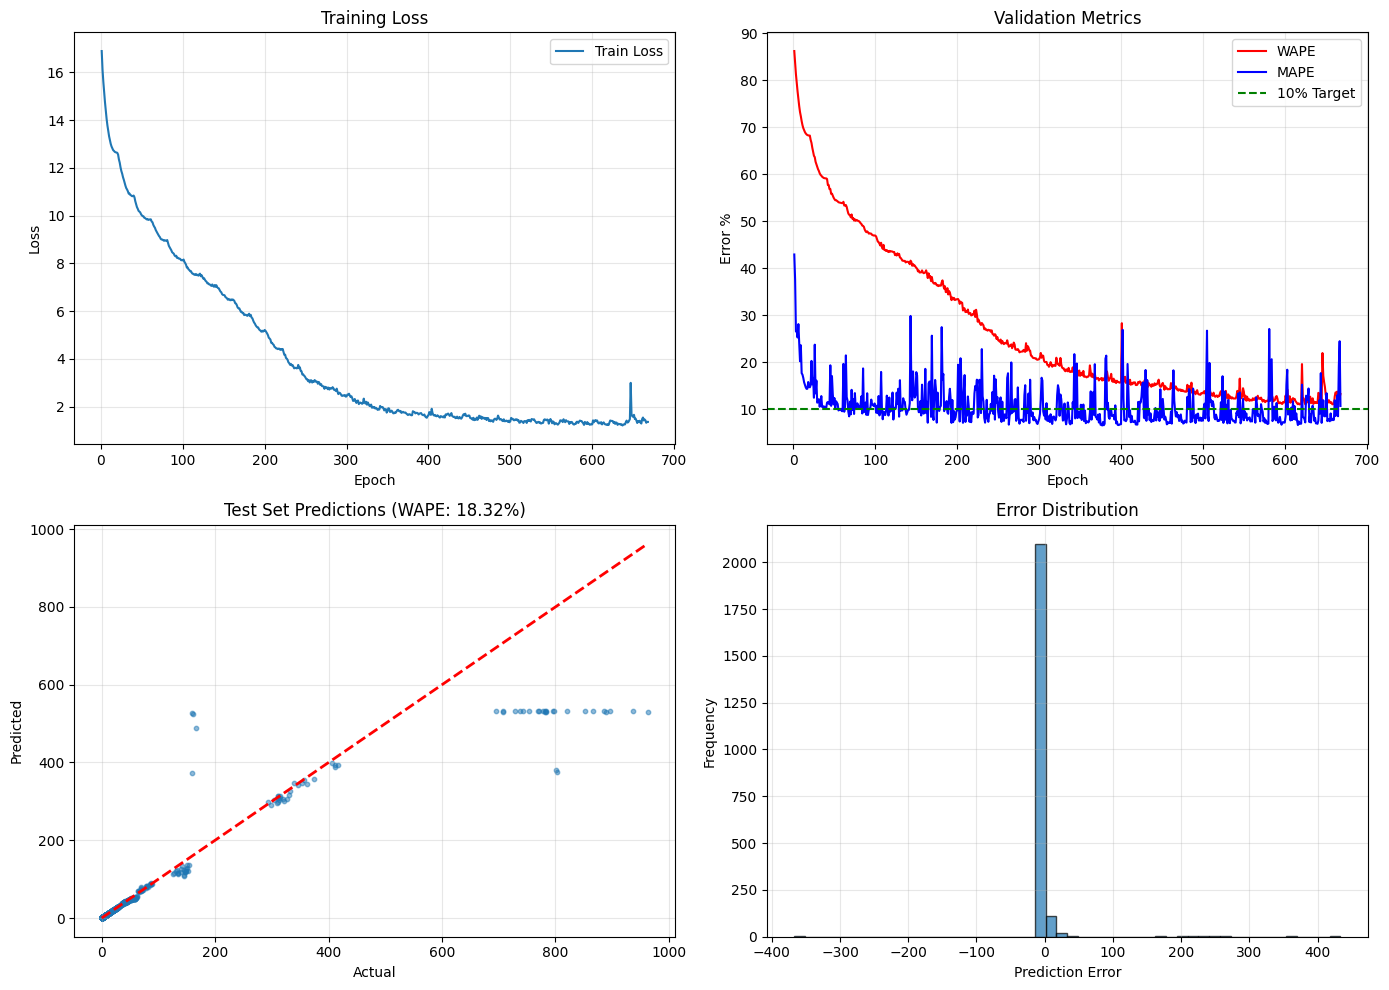

Results saved to C:\Users\FA004\Desktop\satimg2\training_results.png


In [ ]:
# Visualize results
import matplotlib.pyplot as plt

# Training history
hist_df = pd.DataFrame(history)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(hist_df['epoch'], hist_df['train_loss'], label='Train Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(hist_df['epoch'], hist_df['val_wape'], label='WAPE', color='red')
axes[0, 1].plot(hist_df['epoch'], hist_df['val_mape'], label='MAPE', color='blue')
axes[0, 1].axhline(y=10, color='green', linestyle='--', label='10% Target')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Error %')
axes[0, 1].set_title('Validation Metrics')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].scatter(test_targets, test_preds, alpha=0.5, s=10)
axes[1, 0].plot([test_targets.min(), test_targets.max()], 
                [test_targets.min(), test_targets.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Actual')
axes[1, 0].set_ylabel('Predicted')
axes[1, 0].set_title(f'Test Set Predictions (WAPE: {test_metrics["wape"]:.2f}%)')
axes[1, 0].grid(True, alpha=0.3)

errors = test_targets.flatten() - test_preds.flatten()
axes[1, 1].hist(errors, bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Prediction Error')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Error Distribution')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(WORKSPACE / 'training_results.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Results saved to {WORKSPACE / "training_results.png"}')

In [18]:
# Per-country analysis
print('Per-country test performance:')
print('-' * 60)

country_metrics = []
for country in test_results['Country'].unique():
    country_data = test_results[test_results['Country'] == country]
    metrics = compute_metrics(country_data['demand_twh'].values, country_data['predicted'].values)
    country_metrics.append({
        'Country': country,
        'MAE': metrics['mae'],
        'MAPE': metrics['mape'],
        'WAPE': metrics['wape'],
        'Samples': len(country_data)
    })

country_df = pd.DataFrame(country_metrics).sort_values('WAPE')

print('\nTop 10 best performing countries:')
print(country_df.head(10).to_string(index=False))

print('\nTop 10 worst performing countries:')
print(country_df.tail(10).to_string(index=False))

country_df.to_csv(WORKSPACE / 'country_performance.csv', index=False)
print(f'\nCountry-level results saved to {WORKSPACE / "country_performance.csv"}')

Per-country test performance:
------------------------------------------------------------

Top 10 best performing countries:
       Country      MAE     MAPE     WAPE  Samples
         Spain 0.119372 0.634784 0.630279       26
  South Africa 0.141931 0.741031 0.748490       26
       Belgium 0.050076 0.805969 0.786105       26
   Netherlands 0.071929 0.786287 0.792379       26
United Kingdom 0.178413 0.787227 0.803233       26
        France 0.309070 0.923041 0.909828       26
         Italy 0.224002 0.916162 0.931764       26
       Ukraine 0.072748 0.955947 0.955947       26
         Chile 0.069309 0.973318 0.986418       26
          Iran 0.315891 1.017683 0.994873       26

Top 10 worst performing countries:
           Country        MAE      MAPE      WAPE  Samples
            Latvia   0.097347 19.621793 18.544375       26
          Mongolia   0.167717 21.526852 23.231953       26
Bosnia Herzegovina   0.227375 28.383991 26.158200       26
            Kosovo   0.167684 30.768756 2